In [1]:
from functools import cached_property
from mlflux.predictor import FluxANNs
import torch
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt

from mlflux.datafunc import data_split_psd
from mlflux.ann import RealFluxDataset


In [ ]:
psd = xr.load_dataset('../../data/Processed/psd.nc')

# 77, 69, 83, 78, 87, 72, 71, 68, 67, 73
split1 = [[69, 83, 78, 87, 72, 71, 68, 67, 73], [77], [77]]
split2 = [[77, 83, 78, 87, 72, 71, 68, 67, 73], [69], [69]]
split3 = [[77, 69, 78, 87, 72, 71, 68, 67, 73], [83], [83]]
split4 = [[77, 69, 83, 78, 68, 67, 73], [87, 72, 71], [87, 72, 71]]
split5 = [[77, 69, 83, 78, 87, 72, 71, 67, 73], [68], [68]]
split6 = [[77, 69, 83, 68, 87, 72, 71], [78, 67, 73], [78, 67, 73]]
split_ensem = [split1, split2, split3, split4, split5, split6]

training_ds, validating_ds, testing_ds = data_split_psd(psd, split=split1, PLOT=True, XVIS='samples')

In [7]:
from scipy.stats import wasserstein_distance, norm

def wasserstein_to_normal (x, normsize=10000):
    ''' x is a series of samples. '''
    r = norm.rvs(size=normsize)
    return wasserstein_distance(x,r)
    

In [9]:


class Flux44(FluxANNs):
    
    @cached_property
    def Xscale(self):
        # mean of x1, mean of x2
        mean = torch.tensor(np.array([0,0,0,0]).reshape(1,-1).astype('float32'))
        # std of x1, std of x2 (or scale)
        scale = torch.tensor(np.array([20,20,20,100]).reshape(1,-1).astype('float32'))
        return {'mean':mean,'scale':scale}
        
    @cached_property
    def Yscale(self):
        mean = torch.tensor(np.array([0,0,-8,-90]).reshape(1,-1).astype('float32'))
        scale = torch.tensor(np.array([0.1,0.1,20.,50.]).reshape(1,-1).astype('float32'))
        return {'mean':mean,'scale':scale}
    
    def evaluate_uniform(self):
        pass
    
    def dist_distance(self,):
        pass 

In [ ]:
model.pred_var(validating_data.X)

In [10]:
para1 = {'n_in':4,'n_out':3,'hidden_channels':[16,16]}
para2 = {'n_in':4,'n_out':3,'hidden_channels':[16,16]}
model = Flux43({'mean_ann_para':para1, 'var_ann_para':para2})

def sample_weights(x):
    return np.where(x > 18, 100.0, 1.0)

# from mlflux.ann import sample_weights

# Initiate the Dataset class and use default weighting
training_data = RealFluxDataset(training_ds, input_keys=['U','tsea','tair','rh'], 
                                output_keys=['taucx','taucy','hsc','hlc'],
                                weightfunc=sample_weights)
validating_data = RealFluxDataset(validating_ds, input_keys=['U','tsea','tair','rh'], output_keys=['taucx','hsc','hlc'],
                                weightfunc=sample_weights)
testing_data = RealFluxDataset(testing_ds, input_keys=['U','tsea','tair','rh'], output_keys=['taucx','hsc','hlc'],
                                weightfunc=sample_weights)

In [13]:
training_paras = {'batchsize':100, 'num_epochs':400, 'lr':1e-3, 'gamma':0.2}
log, training_data_cp = model.fit(training_data,validating_data,training_paras)

Epoch [1/400], Loss: 5.27387785
Epoch [2/400], Loss: 3.80810576
Epoch [3/400], Loss: 2.15110952
Epoch [4/400], Loss: 1.04612564
Epoch [5/400], Loss: 2.64579454
Epoch [6/400], Loss: 2.25046739
Epoch [7/400], Loss: 1.36071668
Epoch [8/400], Loss: 2.01951793
Epoch [9/400], Loss: 0.62115685
Epoch [10/400], Loss: 3.26371328
Epoch [11/400], Loss: 1.36357637
Epoch [12/400], Loss: 0.25423442
Epoch [13/400], Loss: 1.56677641
Epoch [14/400], Loss: 0.49601186
Epoch [15/400], Loss: 0.12376271
Epoch [16/400], Loss: 0.00550324
Epoch [17/400], Loss: 0.88908259
Epoch [18/400], Loss: 0.39386838
Epoch [19/400], Loss: -0.07035284
Epoch [20/400], Loss: 0.01271316
Epoch [21/400], Loss: 0.76088274
Epoch [22/400], Loss: -0.27633649
Epoch [23/400], Loss: -0.80723503
Epoch [24/400], Loss: -0.16601862
Epoch [25/400], Loss: -0.41625156
Epoch [26/400], Loss: 0.77540853
Epoch [27/400], Loss: -0.98045751
Epoch [28/400], Loss: -0.58216129
Epoch [29/400], Loss: -1.39633841
Epoch [30/400], Loss: -0.51505821
Epoch [31/

In [18]:
model.save(fname="../../saved_model/full_anns")

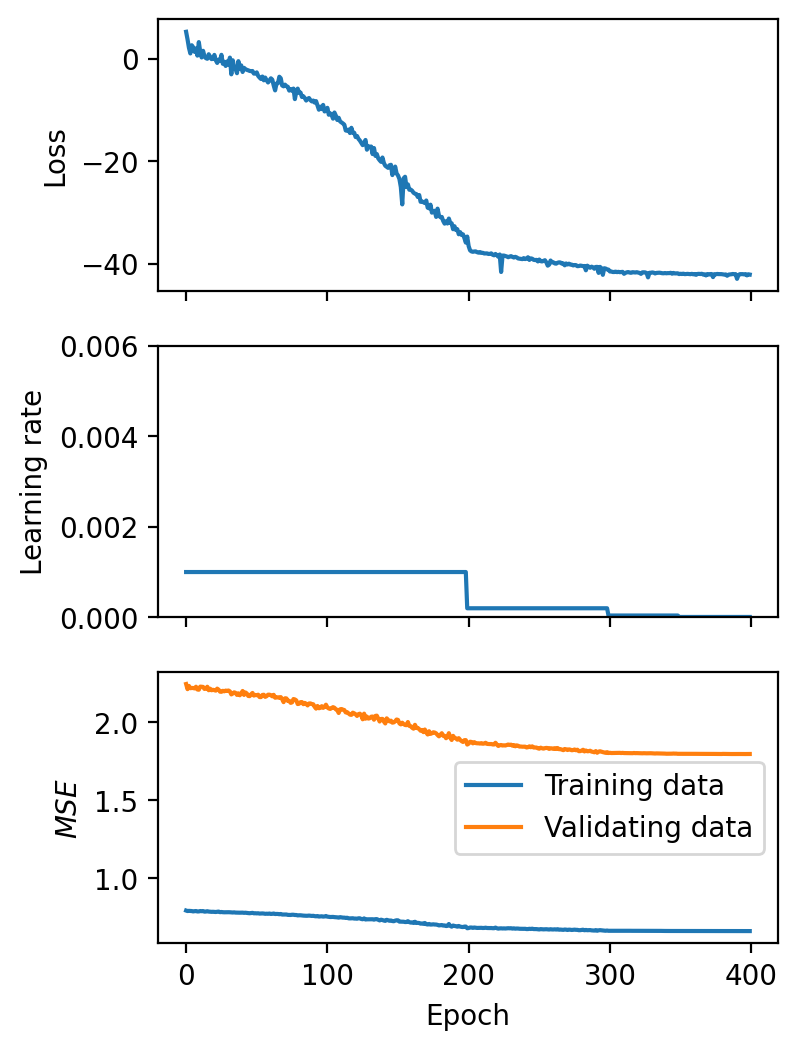

In [14]:
fig, axes = plt.subplots(3,1,sharex=True,figsize=[4,6],dpi=200)

log['training_mse'] = np.array(log['training_mse'])
log['training_r2'] = np.array(log['training_r2'])
log['validating_mse'] = np.array(log['validating_mse'])
log['validating_r2'] = np.array(log['validating_r2'])

axes[0].plot(log['LLLoss'])
axes[0].set_ylabel('Loss')
# axes[0].set_ylim([-400,0])
axes[1].plot(log['lr'])
axes[1].set_ylabel('Learning rate')
axes[1].set_ylim([0,0.006])
axes[2].plot(log['training_mse'][:,1], label='Training data')
axes[2].plot(log['validating_mse'][:,1], label='Validating data')
axes[2].set_ylabel(r'$MSE$')
axes[2].set_xlabel('Epoch')
axes[2].legend()
# axes[2].set_ylim([0,0.02])

In [15]:
def plot_feature(ax, X, Y_truth, Y_pred, LEGEND=True):
    mse = torch.mean((Y_truth-Y_pred)**2)
    r2 = 1 - mse/torch.var(Y_truth)
    ax.plot(X,Y_truth, '.', markersize=0.5, label='Measurements')
    ax.plot(X,Y_pred, '.', markersize=0.5, label='Prediction (of mean) \nr2=%.4f, mse=%.4f' %(r2, mse))
    if LEGEND:
        ax.legend(fancybox=False)
    
def plotting (data):
    fig, axes = plt.subplots(3, 2, figsize=[8,12], dpi=200)
    
    feature = 0; Y_pred = model.pred_mean(data.X)[:,feature]
    ax = axes[0,0]; plot_feature(ax,data.X[:,0],data.Y[:,feature],Y_pred.detach())
    ax.set_ylim([0,1]); ax.set_xlim([0,20])
    ax.set_xlabel('$U$'); ax.set_ylabel('Momentum flux')
    ax = axes[0,1]; plot_feature(ax,data.X[:,1]-data.X[:,2],data.Y[:,feature],Y_pred.detach(), LEGEND=False)
    ax.set_ylim([0,1]); ax.set_xlim([-2,5])
    ax.set_xlabel('$T_o-T_a$')
    
    feature = 1; Y_pred = model.pred_mean(data.X)[:,feature]
    ax = axes[1,0]; plot_feature(ax,data.X[:,0],data.Y[:,feature],Y_pred.detach())
    ax.set_ylim([-60,20]); ax.set_xlim([0,20])
    ax.set_xlabel('$U$'); ax.set_ylabel('Sensible heat flux')
    ax = axes[1,1]; plot_feature(ax,data.X[:,1]-data.X[:,2],data.Y[:,feature],Y_pred.detach(), LEGEND=False)
    ax.set_ylim([-60,20]); ax.set_xlim([-2,5])
    ax.set_xlabel('$T_o-T_a$')
    
    feature = 2; Y_pred = model.pred_mean(data.X)[:,feature]
    ax = axes[2,0]; plot_feature(ax,data.X[:,0],data.Y[:,feature],Y_pred.detach())
    ax.set_ylim([-200,0]); ax.set_xlim([0,20])
    ax.set_xlabel('$U$'); ax.set_ylabel('Latent heat flux')
    ax = axes[2,1]; plot_feature(ax,data.X[:,3],data.Y[:,feature],Y_pred.detach(), LEGEND=False)
    ax.set_ylim([-200,0]); ax.set_xlim([40,100])
    ax.set_xlabel(r'$RH(\%)$'); 
    
    return fig
    
    

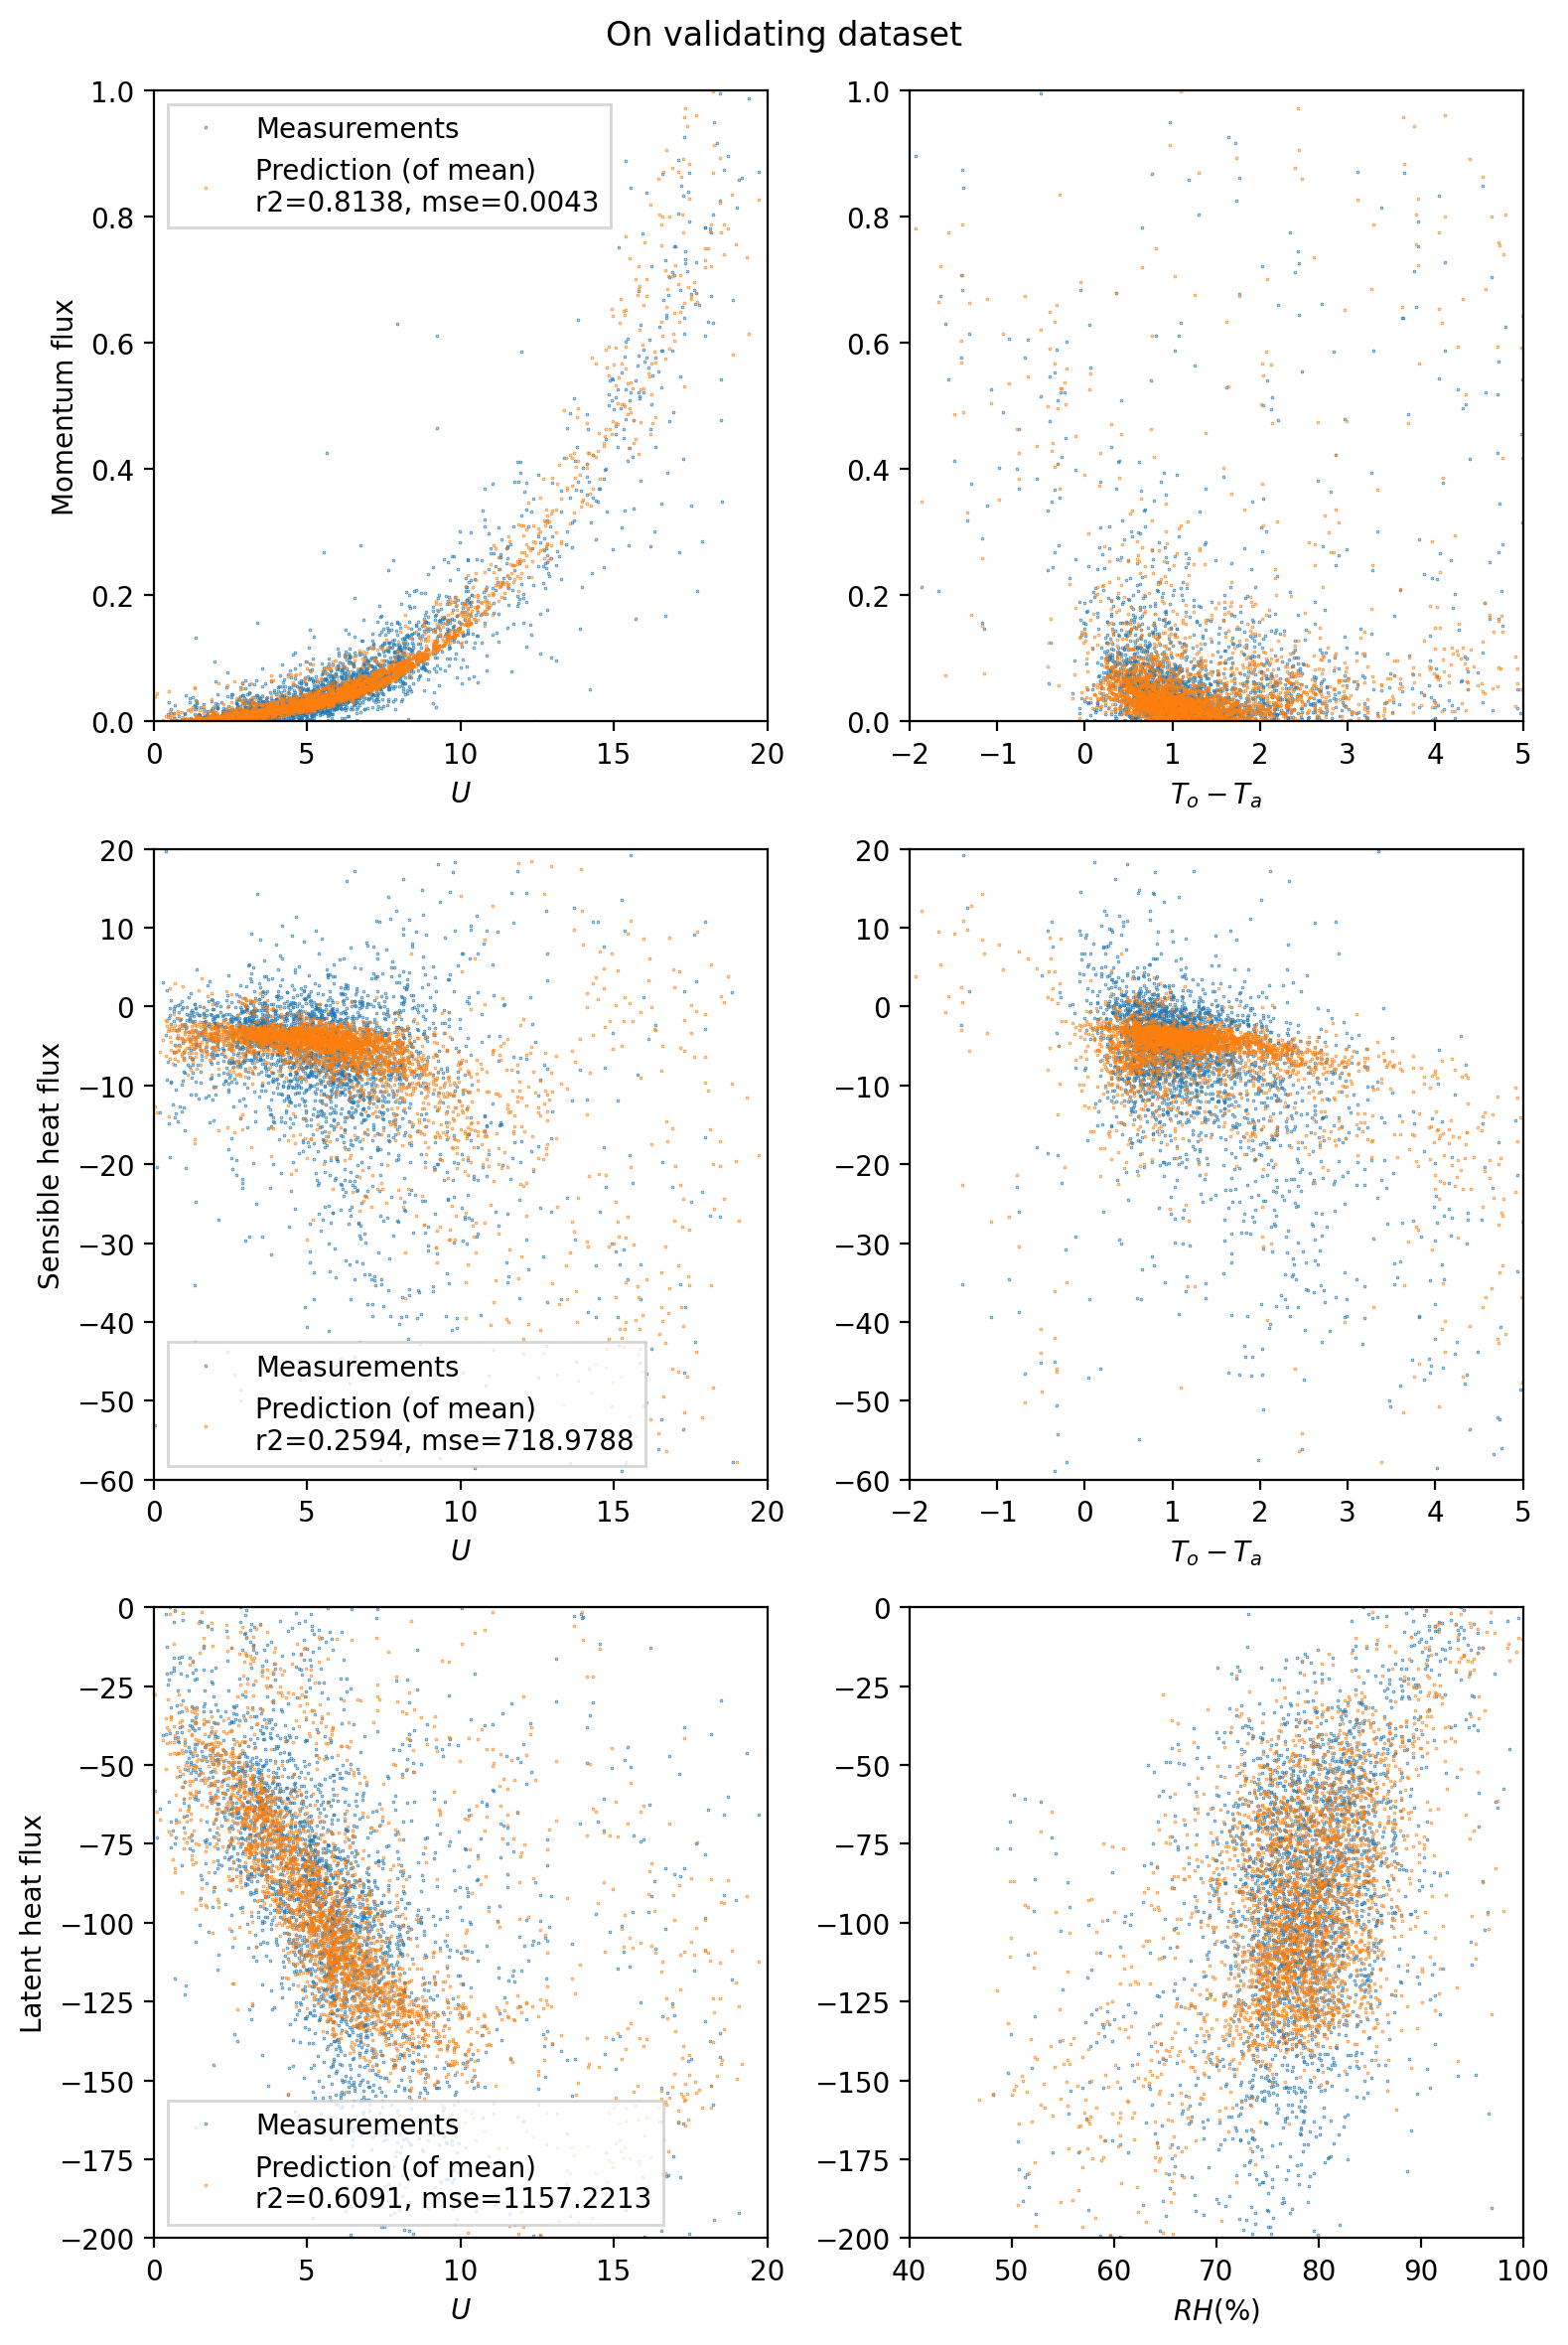

In [16]:
fig = plotting(validating_data)
fig.suptitle('On validating dataset'); fig.tight_layout(); fig.subplots_adjust(top=0.95)

In [91]:
bulk_keys = ['taubx','hsb','hlb']
for data,ds in zip((training_data, validating_data, testing_data),
                   (training_ds, validating_ds, testing_ds)):  
    data.Y_Bulk = torch.tensor(np.hstack([ds[key].values.reshape(-1,1) for key in bulk_keys]).astype('float32'))
    mse_bulk = []; r2_bulk = []
    for i in range(len(bulk_keys)):
        mse = torch.mean((data.Y[:,i]-data.Y_Bulk[:,i])**2)
        r2 = 1 - mse/torch.var(data.Y[:,i])
        mse_bulk.append(mse); r2_bulk.append(r2)
    data.mse_bulk = np.array(mse_bulk); data.r2_bulk = np.array(r2_bulk)

In [98]:
data = validating_data
print('Bulk r2 %.4f, mse %.4f' %(data.r2_bulk[0], data.mse_bulk[0]))

Bulk r2 0.8784, mse 0.0012
